<a href="https://colab.research.google.com/github/shlee0619/Project_Disease/blob/main/0212%EC%BD%94%EB%A1%9C%EB%82%98(%EC%B5%9C%EC%A2%85%EB%B3%B8_%EC%B4%88%EC%95%88)2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
########################################
# 0. 환경 설정 및 라이브러리 설치 (Colab)
########################################
# Google Drive 연동 (Colab 환경인 경우)
from google.colab import drive
drive.mount('/content/gdrive')

# 필요한 라이브러리 설치
!pip install optuna keras-tuner statsmodels prophet tensorflow==2.12.0 tensorflow-addons==0.23.0 keras-tcn xgboost

########################################
# 1. 라이브러리 Import 및 한글 폰트 설정
########################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Scikit-learn
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

# Statsmodels & Prophet
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

# TensorFlow / Keras & TCN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, clone_model, Model
from tensorflow.keras.layers import (InputLayer, Dense, Dropout, LSTM,
                                     SimpleRNN, GRU, Conv1D, MaxPooling1D, Flatten)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tcn import TCN

# XGBoost
from xgboost import XGBRegressor

# Optuna
import optuna

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 한글 폰트 설정 (Colab)
!apt-get update -qq
!apt-get install -qq fonts-nanum
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 임포트 및 한글 폰트 설정 완료!")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
라이브러리 임포트 및 한글 폰트 설정 완료!


In [ ]:
########################################
# 2. 데이터 로드 및 전처리
########################################
def load_data(data_path):
    """
    여러 인코딩 방식으로 CSV 파일을 불러옵니다.
    """
    try:
        try:
            df_ = pd.read_csv(data_path, encoding='cp949')
        except UnicodeDecodeError:
            try:
                df_ = pd.read_csv(data_path, encoding='latin-1')
            except UnicodeDecodeError:
                df_ = pd.read_csv(data_path, encoding='cp1252')
        print("[INFO] 데이터 불러오기 성공!")
        return df_
    except FileNotFoundError:
        print(f"[ERROR] 파일을 찾을 수 없습니다. 경로: {data_path}")
    except Exception as e:
        print("[ERROR] 예기치 못한 에러 발생:", e)

DATA_PATH = '/content/gdrive/MyDrive/hwda02/data/Processed_COVID_Data_Filled_Plus_Traffic.csv'
df = load_data(DATA_PATH)

[INFO] 데이터 불러오기 성공!


In [ ]:

# 원본 변수 목록
original = ['SO2','CO','O3','NO2','PM10','PM25','평균기온(℃)','평균일강수량(mm)','평균풍속(m/s)','평균습도(%rh)','일조합(hr)','일사합(MJ/m2)','Traffic']

# Cases 차분 변수 추가
df['Cases_Diff'] = df['Cases'].diff(1)

# Date 컬럼 처리 및 정렬
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df = df.sort_values('Date').dropna(subset=['Date']).reset_index(drop=True)

In [ ]:

# 간단 EDA 출력
print("\n데이터 예시(상위 5행):")
print(df.head())
print("\n데이터 info:")
print(df.info())
print("\n데이터 통계치:")
print(df.describe())


데이터 예시(상위 5행):
        Date  Cases       SO2        CO        O3       NO2       PM10  \
0 2020-02-15      3  0.003458  0.640453  0.026375  0.023998  54.950811   
1 2020-02-16      2  0.002526  0.440016  0.031002  0.009046  19.467364   
2 2020-02-17      1  0.002634  0.371011  0.032432  0.009166  25.063707   
3 2020-02-18      1  0.003014  0.412110  0.027515  0.016124  23.034546   
4 2020-02-19      2  0.003434  0.523471  0.019764  0.027449  30.993362   

        PM25  평균기온(℃)  평균최고기온(℃)  ...  Cases_lag5  Cases_lag6  Cases_lag7  \
0  40.078319      9.4       15.9  ...         2.0         3.0         2.0   
1  12.046308      1.8        8.3  ...         2.0         2.0         3.0   
2  12.395139     -3.0       -0.5  ...         3.0         2.0         2.0   
3  14.064703     -1.7        4.0  ...         4.0         3.0         2.0   
4  20.401319      2.1        9.2  ...         2.0         4.0         3.0   

   Cases_lag8  Cases_lag9  Cases_lag10  Cases_lag11  Cases_lag12  Cases_lag1

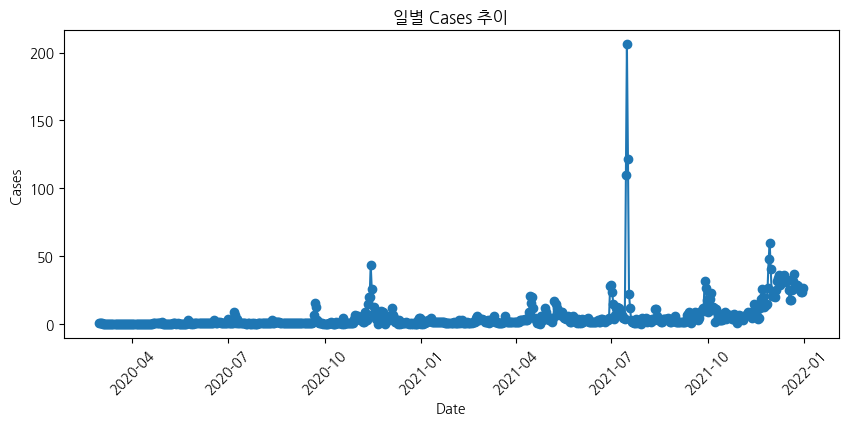

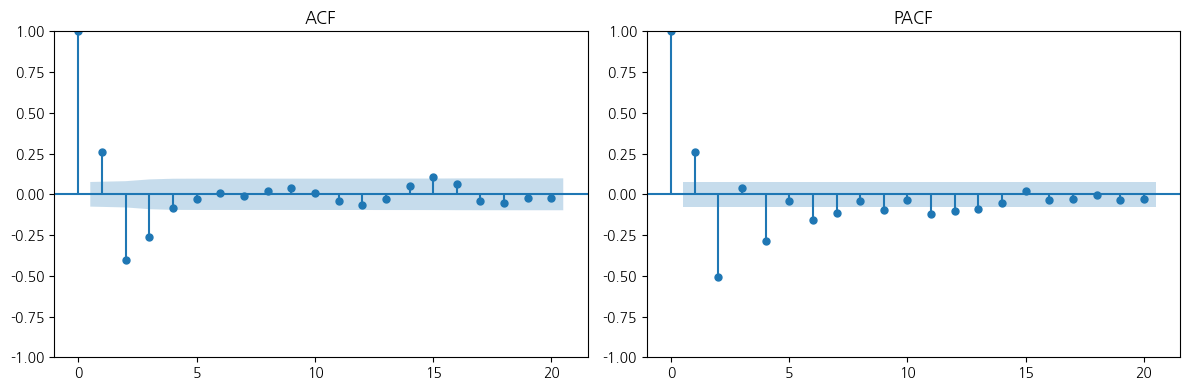

In [ ]:
########################################
# 3. 간단 EDA (시각화)
########################################
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Cases'], marker='o')
plt.title("일별 Cases 추이")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.xticks(rotation=45)
plt.show()

# ACF 및 PACF 플롯
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(df['Cases_Diff'].dropna(), lags=20, ax=plt.gca())
plt.title("ACF")
plt.subplot(1,2,2)
plot_pacf(df['Cases_Diff'].dropna(), lags=20, ax=plt.gca(), method='ywm')
plt.title("PACF")
plt.tight_layout()
plt.show()

In [ ]:

########################################
# 4. Lag Feature 생성
########################################
def create_lag_features(dataframe, col_targets, lags):
    """
    col_targets에 대해 지정된 lags 만큼의 새로운 컬럼 생성.
    예: lags=(1,7,14) → 'col_target_lag1', 'col_target_lag7', 'col_target_lag14'
    """
    df_ = dataframe.copy()
    for col_target in col_targets:
        for lag in lags:
            df_[f"{col_target}_lag{lag}"] = df_[col_target].shift(lag)
    df_.dropna(inplace=True)
    return df_

df = create_lag_features(df, ['O3', 'PM25', '평균기온(℃)', '평균습도(%rh)','평균풍속(m/s)','Cases'], [1,2,3,4,5,6,7,8,9,10,11,12,13,14])

In [ ]:
import statsmodels.api as sm

# 종속변수: 'Cases'
y = df['Cases']

# 독립변수: 'Cases'와 'Date' 컬럼을 제외한 나머지 모든 컬럼
X = df.drop(['Cases', 'Date'], axis=1)

# 상수항 추가
X = sm.add_constant(X)

# OLS 회귀 모델 적합
model = sm.OLS(y, X).fit()

# 회귀 결과 요약 출력 (계수, p-value, R-squared 등 확인 가능)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Cases   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.195e+20
Date:                Wed, 12 Feb 2025   Prob (F-statistic):               0.00
Time:                        06:14:15   Log-Likelihood:                 12265.
No. Observations:                 658   AIC:                        -2.432e+04
Df Residuals:                     551   BIC:                        -2.384e+04
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -3.233e-10   3.55e-09     

In [ ]:

# SARIMAX 튜닝 시 사용한 best feature (예시)
# feature_cols = ['SO2','CO','O3','NO2','O3_lag10','평균기온(℃)_lag10', 'PM25_lag13','평균풍속(m/s)_lag13','Traffic', 'Cases_lag1']
feature_cols = ['SO2','CO','O3','NO2','O3_lag10','평균기온(℃)_lag10','최고기온(℃)', '평균풍속(m/s)','Traffic','Cases_lag1']

In [ ]:

########################################
# 6. 시퀀스 데이터 생성 함수
########################################
def make_sequence_data(X_scaled, y_values, window):
    """
    window 길이만큼 슬라이딩 윈도우로 시퀀스 데이터를 생성합니다.
    X_seq: [샘플 수, window, feature 수]
    y_seq: window 이후의 target 값
    """
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - window):
        X_seq.append(X_scaled[i:i+window])
        y_seq.append(y_values[i+window])
    return np.array(X_seq), np.array(y_seq)

In [ ]:
########################################
# 7. 모델 성능 평가 함수
########################################
def evaluate_performance(y_true, y_pred, model_name="Model"):
    mae_value = mean_absolute_error(y_true, y_pred)
    rmse_value = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_value = mean_absolute_percentage_error(y_true, y_pred)
    print(f"[{model_name}] MAE={mae_value:.3f}, RMSE={rmse_value:.3f}, MAPE={mape_value:.3f}")
    return {'model': model_name, 'MAE': mae_value, 'RMSE': rmse_value, 'MAPE': mape_value}

In [ ]:
########################################
# 5. Train/Test 분리 (날짜 기준)
########################################
#  예시로 2021-07-31을 기준으로 분할
########################################
split_date = pd.to_datetime('2021-07-31')
train_df = df[df['Date'] <= split_date].copy()
test_df = df[df['Date'] > split_date].copy()

print(f"Train={train_df.shape}, Test={test_df.shape}")

X_train = train_df[feature_cols]
y_train = train_df['Cases']
X_test  = test_df[feature_cols]
y_test  = test_df['Cases']

# 결측 제거(Shift로 생긴 결측)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

print("최종 학습세트 크기:", X_train.shape, "테스트세트 크기:", X_test.shape)

Train=(505, 108), Test=(153, 108)
최종 학습세트 크기: (505, 10) 테스트세트 크기: (153, 10)


In [ ]:
########################################
# 6. 데이터 스케일링 (필요시)
########################################
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# y도 스케일링 (딥러닝 모델에서 사용)
scaler_y = MinMaxScaler()
y_train_scaled = y_train
y_test_scaled = y_test

In [ ]:
########################################
# 8-1. SARIMAX (ARIMAX) 예시
########################################
feature_cols = ['SO2','CO','O3','NO2','O3','O3_lag10','Cases_lag1','Cases_Diff']
# feature_cols = ['SO2','CO','O3','NO2','O3','O3_lag8','평균풍속(m/s)_lag9','평균습도(%rh)_lag9','Traffic','Cases_lag1']
def train_sarimax(train_data, test_data, exog_cols, order=(1,0,1), seasonal_order=(0,0,1,7)):
    """
    SARIMAX(ARIMAX) 모델을 학습하고 예측값을 반환.
    order, seasonal_order는 필요에 따라 조정.
    """
    # train
    y_train_sar = train_data['Cases']
    X_train_sar = train_data[exog_cols]

    # test
    y_test_sar  = test_data['Cases']
    X_test_sar  = test_data[exog_cols]

    model = sm.tsa.statespace.SARIMAX(
        endog=y_train_sar,
        exog=X_train_sar,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    result = model.fit(disp=False)
    print("SARIMAX 학습 완료! summary:\n", result.summary())

    # 예측
    n_test = len(y_test_sar)
    forecast = result.predict(
        start=len(y_train_sar),
        end=len(y_train_sar)+n_test-1,
        exog=X_test_sar
    )
    return forecast


sarimax_pred = train_sarimax(train_df, test_df, exog_cols=feature_cols)
sarimax_result = evaluate_performance(y_test, sarimax_pred, model_name="SARIMAX")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


SARIMAX 학습 완료! summary:
                                      SARIMAX Results                                     
Dep. Variable:                             Cases   No. Observations:                  505
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 7)   Log Likelihood                5254.561
Date:                           Wed, 12 Feb 2025   AIC                         -10485.122
Time:                                   08:14:46   BIC                         -10434.643
Sample:                                        0   HQIC                        -10465.308
                                           - 505                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SO2        -7.398e-12         -0        inf      0.000    -7.4e-12    -7.4e-12
CO          3.859e

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
########################################
# 5. Train/Validation/Test 분리 및 스케일링
########################################
feature_cols = ['SO2','CO','O3','NO2','O3','최고기온(℃)', '평균풍속(m/s)','Traffic','Cases_lag1']

# 날짜 기준 분할 (Validation < Test)
split_date_test = pd.to_datetime('2021-07-31')
split_date_val = pd.to_datetime('2021-05-31')

train_df = df[df['Date'] <= split_date_val].copy()
val_df = df[(df['Date'] > split_date_val) & (df['Date'] <= split_date_test)].copy()
test_df = df[df['Date'] > split_date_test].copy()
print(f"Train={train_df.shape}, Validation={val_df.shape}, Test={test_df.shape}")

# 타깃 변수 (Cases)
y_train = train_df['Cases']
y_val   = val_df['Cases']
y_test  = test_df['Cases']

# 독립변수 (Feature)
X_train = train_df[feature_cols].dropna()
X_val   = val_df[feature_cols].dropna()
X_test  = test_df[feature_cols].dropna()

# Feature 스케일링 (y는 스케일링하지 않음)
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = y_train.values
y_val_scaled   = y_val.values
y_test_scaled  = y_test.values

Train=(444, 108), Validation=(61, 108), Test=(153, 108)


In [ ]:
########################################
# 8. 모델 빌드 함수 (다층 구성 지원)
########################################
def build_lstm_model(input_shape, lstm_units, dropout_rate, learning_rate, num_layers):
    model = Sequential()
    model.add(LSTM(lstm_units, activation='tanh', return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        return_seq = (i < num_layers - 1)
        model.add(LSTM(lstm_units, activation='tanh', return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model

def build_gru_model(input_shape, gru_units, dropout_rate, learning_rate, num_layers):
    model = Sequential()
    model.add(GRU(gru_units, activation='tanh', return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        return_seq = (i < num_layers - 1)
        model.add(GRU(gru_units, activation='tanh', return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model

def build_rnn_model(input_shape, rnn_units, dropout_rate, learning_rate, num_layers):
    model = Sequential()
    model.add(SimpleRNN(rnn_units, activation='tanh', return_sequences=(num_layers > 1), input_shape=input_shape))
    for i in range(1, num_layers):
        return_seq = (i < num_layers - 1)
        model.add(SimpleRNN(rnn_units, activation='tanh', return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model

def build_cnn_model(input_shape, conv_filters, kernel_size, dropout_rate, optimizer_choice, learning_rate, num_layers=1):
    model = Sequential()
    # 첫 번째 Conv1D 레이어
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu',
                     input_shape=input_shape, padding='same'))
    # 추가 Conv1D 및 Dropout 레이어
    for i in range(1, num_layers):
        model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', padding='same'))
        model.add(Dropout(dropout_rate))
    # 시간 축을 1차원으로 flatten
    model.add(Flatten())
    # 최종 출력층
    model.add(Dense(1))

    # 옵티마이저 설정
    if optimizer_choice == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        opt = Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss=tf.keras.losses.MeanAbsolutePercentageError())
    return model


In [ ]:

########################################
# 9. Optuna Objective Functions (Time Step 및 num_layers 튜닝)
########################################

In [ ]:
def objective_lstm_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    lstm_units = trial.suggest_int("lstm_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 10  # 빠른 튜닝을 위한 epoch 수 축소

    model = build_lstm_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        lstm_units=lstm_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        num_layers=num_layers
    )
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    return min(history.history['val_loss'])

In [ ]:
def objective_gru_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    gru_units = trial.suggest_int("gru_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 10

    model = build_gru_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        gru_units=gru_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        num_layers=num_layers
    )
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    return min(history.history['val_loss'])

In [ ]:
def objective_rnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    rnn_units = trial.suggest_int("rnn_units", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 10

    model = build_rnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        rnn_units=rnn_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate,
        num_layers=num_layers
    )
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stop]
    )
    return min(history.history['val_loss'])

In [ ]:
def objective_cnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps):
    conv_filters = trial.suggest_int('conv_filters', 16, 64, step=16)
    kernel_size = trial.suggest_int('kernel_size', 2, 5)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5, step=0.1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    optimizer_choice = trial.suggest_categorical('optimizer_choice', ['adam', 'rmsprop', 'sgd'])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    epochs = 5

    model = build_cnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        conv_filters=conv_filters,
        kernel_size=kernel_size,
        dropout_rate=dropout_rate,
        optimizer_choice=optimizer_choice,
        learning_rate=learning_rate,
        num_layers=num_layers
    )

    cv_mapes = []
    from sklearn.model_selection import TimeSeriesSplit
    tscv_ = TimeSeriesSplit(n_splits=3)
    for train_idx, val_idx in tscv_.split(X_train_seq):
        X_train_cv, X_val_cv = X_train_seq[train_idx], X_train_seq[val_idx]
        y_train_cv, y_val_cv = y_train_seq[train_idx], y_train_seq[val_idx]
        model_cv = clone_model(model)
        model_cv.set_weights(model.get_weights())
        model_cv.compile(optimizer=tf.keras.optimizers.get(optimizer_choice),
                           loss=tf.keras.losses.MeanAbsolutePercentageError(),
                           metrics=['mse', tf.keras.metrics.MeanAbsolutePercentageError()])
        hist = model_cv.fit(
            X_train_cv, y_train_cv,
            validation_data=(X_val_cv, y_val_cv),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            shuffle=False
        )
        cv_mapes.append(hist.history['val_mean_absolute_percentage_error'][-1])
    return np.mean(cv_mapes)

In [ ]:
########################################
# 5. Train/Test 분리 (날짜 기준)
########################################
#  예시로 2021-07-31을 기준으로 분할
########################################
# split_date = pd.to_datetime('2021-07-31')
# train_df = df[df['Date'] <= split_date].copy()
# test_df = df[df['Date'] > split_date].copy()

# print(f"Train={train_df.shape}, Test={test_df.shape}")

# X_train = train_df[feature_cols]
# y_train = train_df['Cases']
# X_test  = test_df[feature_cols]
# y_test  = test_df['Cases']

# # 결측 제거(Shift로 생긴 결측)
# X_train = X_train.dropna()
# y_train = y_train.loc[X_train.index]

# X_test = X_test.dropna()
# y_test = y_test.loc[X_test.index]

# print("최종 학습세트 크기:", X_train.shape, "테스트세트 크기:", X_test.shape)

Train=(519, 108), Test=(153, 108)
최종 학습세트 크기: (519, 10) 테스트세트 크기: (153, 10)


In [ ]:
########################################
# 10. Time Step 및 Hyperparameter 튜닝 실행 (Validation Set 사용)
########################################
timesteps_candidates = range(12, 15)
dl_results_timestep_tuning = []

for timesteps in timesteps_candidates:
    print(f"\n===== Time Steps: {timesteps} =====")

    # 데이터 준비: Feature/Target 분리 및 스케일링 (Validation set 포함)
    X_train_sub = train_df[feature_cols].dropna()
    X_val_sub   = val_df[feature_cols].dropna()
    X_test_sub  = test_df[feature_cols].dropna()

    X_train_scaled_sub = scaler_X.fit_transform(X_train_sub)
    X_val_scaled_sub   = scaler_X.transform(X_val_sub)
    X_test_scaled_sub  = scaler_X.transform(X_test_sub)

    # y index 정렬
    y_train_aligned = y_train.loc[X_train_sub.index]
    y_val_aligned   = y_val.loc[X_val_sub.index]
    y_test_aligned  = y_test.loc[X_test_sub.index]

    # 시퀀스 데이터 생성
    X_train_seq, y_train_seq = make_sequence_data(X_train_scaled_sub, y_train_aligned.values, window=timesteps)
    X_val_seq, y_val_seq     = make_sequence_data(X_val_scaled_sub, y_val_aligned.values, window=timesteps)
    X_test_seq, y_test_seq   = make_sequence_data(X_test_scaled_sub, y_test_scaled, window=timesteps)

    ########################################
    # LSTM 튜닝 및 평가
    ########################################
    study_lstm = optuna.create_study(direction='minimize')
    objective_lstm = lambda trial: objective_lstm_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_lstm.optimize(objective_lstm, n_trials=10)
    best_params_lstm = study_lstm.best_trial.params
    lstm_model = build_lstm_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        lstm_units=best_params_lstm['lstm_units'],
        dropout_rate=best_params_lstm['dropout_rate'],
        learning_rate=best_params_lstm['learning_rate'],
        num_layers=best_params_lstm['num_layers']
    )
    epochs_best = 20
    lstm_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                   epochs=epochs_best, batch_size=best_params_lstm['batch_size'], verbose=0)
    lstm_pred = lstm_model.predict(X_test_seq).flatten()
    lstm_result = evaluate_performance(y_test_seq, lstm_pred, model_name="LSTM")
    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'LSTM', 'Best Params': best_params_lstm, **lstm_result})

    ########################################
    # GRU 튜닝 및 평가
    ########################################
    study_gru = optuna.create_study(direction='minimize')
    objective_gru = lambda trial: objective_gru_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_gru.optimize(objective_gru, n_trials=10)
    best_params_gru = study_gru.best_trial.params
    gru_model = build_gru_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        gru_units=best_params_gru['gru_units'],
        dropout_rate=best_params_gru['dropout_rate'],
        learning_rate=best_params_gru['learning_rate'],
        num_layers=best_params_gru['num_layers']
    )
    gru_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                  epochs=epochs_best, batch_size=best_params_gru['batch_size'], verbose=0)
    gru_pred = gru_model.predict(X_test_seq).flatten()
    gru_result = evaluate_performance(y_test_seq, gru_pred, model_name="GRU")
    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'GRU', 'Best Params': best_params_gru, **gru_result})

    ########################################
    # RNN 튜닝 및 평가
    ########################################
    study_rnn = optuna.create_study(direction='minimize')
    objective_rnn = lambda trial: objective_rnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_rnn.optimize(objective_rnn, n_trials=10)
    best_params_rnn = study_rnn.best_trial.params
    rnn_model = build_rnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        rnn_units=best_params_rnn['rnn_units'],
        dropout_rate=best_params_rnn['dropout_rate'],
        learning_rate=best_params_rnn['learning_rate'],
        num_layers=best_params_rnn['num_layers']
    )
    rnn_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                  epochs=epochs_best, batch_size=best_params_rnn['batch_size'], verbose=0)
    rnn_pred = rnn_model.predict(X_test_seq).flatten()
    rnn_result = evaluate_performance(y_test_seq, rnn_pred, model_name="RNN")
    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'RNN', 'Best Params': best_params_rnn, **rnn_result})

    ########################################
    # CNN 튜닝 및 평가
    ########################################
    study_cnn = optuna.create_study(direction='minimize')
    objective_cnn = lambda trial: objective_cnn_for_timestep(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps)
    study_cnn.optimize(objective_cnn, n_trials=10)
    best_params_cnn = study_cnn.best_trial.params
    cnn_model = build_cnn_model(
        input_shape=(timesteps, X_train_seq.shape[2]),
        conv_filters=best_params_cnn['conv_filters'],
        kernel_size=best_params_cnn['kernel_size'],
        dropout_rate=best_params_cnn['dropout_rate'],
        optimizer_choice=best_params_cnn['optimizer_choice'],
        learning_rate=best_params_cnn['learning_rate'],
        num_layers=best_params_cnn['num_layers']
    )
    cnn_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
                  epochs=epochs_best, batch_size=best_params_cnn['batch_size'], verbose=0)
    cnn_pred = cnn_model.predict(X_test_seq).flatten()
    cnn_result = evaluate_performance(y_test_seq, cnn_pred, model_name="CNN")

    dl_results_timestep_tuning.append({'Time Steps': timesteps, 'Model': 'CNN', 'Best Params': best_params_cnn, **cnn_result})

[I 2025-02-12 03:03:13,315] A new study created in memory with name: no-name-2dc24db2-b404-4cd2-b2b4-b30a267d5903



===== Time Steps: 12 =====


<ipython-input-59-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-12 03:03:24,987] Trial 0 finished with value: 67300.1640625 and parameters: {'lstm_units': 224, 'dropout_rate': 0.1, 'learning_rate': 0.005224379219455054, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 67300.1640625.
[I 2025-02-12 03:03:32,326] Trial 1 finished with value: 27775.51953125 and parameters: {'lstm_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.0013035919162981224, 'batch_size': 64, 'num_layers': 1}. Best is trial 1 with value: 27775.51953125.
[I 2025-02-12 03:03:40,612] Trial 2 finished with value: 24053.251953125 and parameters: {'lstm_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.0038144416027985776, 'batch_size': 64, 'num_

5/5 [==============================] - 1s 20ms/step


[I 2025-02-12 03:07:31,659] A new study created in memory with name: no-name-d0486c79-c736-45ce-8b3d-b0d5729d829b


[LSTM] MAE=12.886, RMSE=17.347, MAPE=1.000


<ipython-input-60-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-12 03:08:18,397] Trial 0 finished with value: 147941.40625 and parameters: {'gru_units': 224, 'dropout_rate': 0.4, 'learning_rate': 0.00045428307231622727, 'batch_size': 16, 'num_layers': 2}. Best is trial 0 with value: 147941.40625.
[I 2025-02-12 03:08:38,629] Trial 1 finished with value: 12217.4384765625 and parameters: {'gru_units': 224, 'dropout_rate': 0.1, 'learning_rate': 0.001665831181115983, 'batch_size': 64, 'num_layers': 3}. Best is trial 1 with value: 12217.4384765625.
[I 2025-02-12 03:08:56,496] Trial 2 finished with value: 1602085.875 and parameters: {'gru_units': 32, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00023079553913086354, 'batch_size

5/5 [==============================] - 1s 37ms/step


[I 2025-02-12 03:11:19,713] A new study created in memory with name: no-name-c39b15df-7ccd-4d4c-83ce-2a3d5bccb27e


[GRU] MAE=12.890, RMSE=17.355, MAPE=1.000


<ipython-input-61-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-12 03:11:29,359] Trial 0 finished with value: 36574.78125 and parameters: {'rnn_units': 192, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0013276702468973216, 'batch_size': 16, 'num_layers': 3}. Best is trial 0 with value: 36574.78125.
[I 2025-02-12 03:11:38,678] Trial 1 finished with value: 2704307.75 and parameters: {'rnn_units': 160, 'dropout_rate': 0.2, 'learning_rate': 0.0016248387017202188, 'batch_size': 64, 'num_layers': 3}. Best is trial 0 with value: 36574.78125.
[I 2025-02-12 03:11:45,610] Trial 2 finished with value: 1790221.5 and parameters: {'rnn_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.000546300825025207, 'batch_size': 64, 'num_layer

5/5 [==============================] - 1s 9ms/step


[I 2025-02-12 03:12:59,606] A new study created in memory with name: no-name-ed2cc704-cecb-43ca-ab73-74ca1df1d547


[RNN] MAE=12.982, RMSE=17.418, MAPE=1.017


[I 2025-02-12 03:13:09,711] Trial 0 finished with value: 2278824.0208333335 and parameters: {'conv_filters': 64, 'kernel_size': 4, 'dropout_rate': 0.4, 'batch_size': 64, 'optimizer_choice': 'adam', 'learning_rate': 0.0014751546706971374, 'num_layers': 3}. Best is trial 0 with value: 2278824.0208333335.
[I 2025-02-12 03:13:19,479] Trial 1 finished with value: 1045809.2838541666 and parameters: {'conv_filters': 48, 'kernel_size': 3, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.00016555273203244369, 'num_layers': 3}. Best is trial 1 with value: 1045809.2838541666.
[I 2025-02-12 03:13:27,248] Trial 2 finished with value: 5102054.59375 and parameters: {'conv_filters': 16, 'kernel_size': 3, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.005151509200195619, 'num_layers': 2}. Best is trial 1 with value: 1045809.2838541666.
[I 2025-02-12 03:13:34,712] Trial 3 finished with value: 1402

5/5 [==============================] - 0s 4ms/step


[I 2025-02-12 03:14:21,440] A new study created in memory with name: no-name-efc0e649-b8b2-4f80-97b8-ccba0eda0b0b


[CNN] MAE=12.880, RMSE=17.338, MAPE=0.999

===== Time Steps: 13 =====


<ipython-input-59-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-12 03:14:32,247] Trial 0 finished with value: 26102.158203125 and parameters: {'lstm_units': 96, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.004742320279873078, 'batch_size': 64, 'num_layers': 2}. Best is trial 0 with value: 26102.158203125.
[I 2025-02-12 03:14:45,861] Trial 1 finished with value: 326157.0 and parameters: {'lstm_units': 96, 'dropout_rate': 0.2, 'learning_rate': 0.0006234334786867698, 'batch_size': 64, 'num_layers': 3}. Best is trial 0 with value: 26102.158203125.
[I 2025-02-12 03:14:52,467] Trial 2 finished with value: 271968.53125 and parameters: {'lstm_units': 96, 'dropout_rate': 0.4, 'learning_rate': 0.00032222378019467504, 'batch_size':

5/5 [==============================] - 2s 17ms/step


[I 2025-02-12 03:18:50,288] A new study created in memory with name: no-name-bc592c9f-e001-4a6f-a89c-f4040e249bee


[LSTM] MAE=12.904, RMSE=17.387, MAPE=1.001


<ipython-input-60-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-12 03:19:40,350] Trial 0 finished with value: 133651.34375 and parameters: {'gru_units': 256, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0034127333057929715, 'batch_size': 16, 'num_layers': 3}. Best is trial 0 with value: 133651.34375.
[I 2025-02-12 03:20:09,967] Trial 1 finished with value: 63976.63671875 and parameters: {'gru_units': 224, 'dropout_rate': 0.1, 'learning_rate': 0.006373869177039096, 'batch_size': 16, 'num_layers': 2}. Best is trial 1 with value: 63976.63671875.
[I 2025-02-12 03:20:26,244] Trial 2 finished with value: 613289.0625 and parameters: {'gru_units': 192, 'dropout_rate': 0.5, 'learning_rate': 0.00028063434828961355, 'batch_size': 3

5/5 [==============================] - 1s 27ms/step


[I 2025-02-12 03:24:17,092] A new study created in memory with name: no-name-66e2ee06-2e95-4157-97e4-ee83b3ac1067


[GRU] MAE=12.897, RMSE=17.383, MAPE=0.999


<ipython-input-61-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-12 03:24:27,704] Trial 0 finished with value: 1656300.875 and parameters: {'rnn_units': 192, 'dropout_rate': 0.4, 'learning_rate': 0.0009530673484798549, 'batch_size': 64, 'num_layers': 3}. Best is trial 0 with value: 1656300.875.
[I 2025-02-12 03:24:37,421] Trial 1 finished with value: 8976269.0 and parameters: {'rnn_units': 96, 'dropout_rate': 0.4, 'learning_rate': 0.00010111980444629212, 'batch_size': 64, 'num_layers': 3}. Best is trial 0 with value: 1656300.875.
[I 2025-02-12 03:24:40,568] Trial 2 finished with value: 1436508.625 and parameters: {'rnn_units': 224, 'dropout_rate': 0.4, 'learning_rate': 0.0006114630400286693, 'batch_size': 64, 'num_layers': 1}. Best 

5/5 [==============================] - 0s 5ms/step


[I 2025-02-12 03:25:29,585] A new study created in memory with name: no-name-f70e195c-0115-4f63-8876-8a886c070023


[RNN] MAE=12.941, RMSE=17.412, MAPE=1.008


[I 2025-02-12 03:25:39,777] Trial 0 finished with value: 2159543.2667643228 and parameters: {'conv_filters': 32, 'kernel_size': 5, 'dropout_rate': 0.5, 'batch_size': 64, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.0003204661244033925, 'num_layers': 3}. Best is trial 0 with value: 2159543.2667643228.
[I 2025-02-12 03:25:46,004] Trial 1 finished with value: 1297464276899157.2 and parameters: {'conv_filters': 32, 'kernel_size': 5, 'dropout_rate': 0.1, 'batch_size': 16, 'optimizer_choice': 'sgd', 'learning_rate': 0.006136025192466369, 'num_layers': 2}. Best is trial 0 with value: 2159543.2667643228.
[I 2025-02-12 03:25:50,355] Trial 2 finished with value: 9707271.4375 and parameters: {'conv_filters': 64, 'kernel_size': 3, 'dropout_rate': 0.2, 'batch_size': 64, 'optimizer_choice': 'rmsprop', 'learning_rate': 0.0008417152899217708, 'num_layers': 1}. Best is trial 0 with value: 2159543.2667643228.
[I 2025-02-12 03:25:55,331] Trial 3 finished with value: 8281340.40625 and parameters: {'c

5/5 [==============================] - 0s 5ms/step


[I 2025-02-12 03:26:37,671] A new study created in memory with name: no-name-849896c5-1f44-4eed-9a79-160d21a51ae5


[CNN] MAE=12.902, RMSE=17.386, MAPE=1.000

===== Time Steps: 14 =====


<ipython-input-59-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-12 03:26:43,810] Trial 0 finished with value: 194073.53125 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.008181607208303522, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 194073.53125.
[I 2025-02-12 03:27:20,622] Trial 1 finished with value: 176421.84375 and parameters: {'lstm_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.005990157052422829, 'batch_size': 32, 'num_layers': 3}. Best is trial 1 with value: 176421.84375.
[I 2025-02-12 03:27:37,217] Trial 2 finished with value: 53924.90234375 and parameters: {'lstm_units': 192, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00039451116377768505, 'batch_size': 3

5/5 [==============================] - 1s 6ms/step


[I 2025-02-12 03:29:28,625] A new study created in memory with name: no-name-dee24a57-71bf-4d4f-a980-05f12ea5d5b4


[LSTM] MAE=12.969, RMSE=17.447, MAPE=1.005


<ipython-input-60-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-12 03:29:40,918] Trial 0 finished with value: 80444.015625 and parameters: {'gru_units': 160, 'dropout_rate': 0.4, 'learning_rate': 0.0003295544746949245, 'batch_size': 64, 'num_layers': 2}. Best is trial 0 with value: 80444.015625.
[I 2025-02-12 03:29:56,805] Trial 1 finished with value: 309278.78125 and parameters: {'gru_units': 64, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0002629105494254676, 'batch_size': 64, 'num_layers': 2}. Best is trial 0 with value: 80444.015625.
[I 2025-02-12 03:30:21,022] Trial 2 finished with value: 1737274.375 and parameters: {'gru_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.008513497680697433, 'batch_size': 32, 'nu

5/5 [==============================] - 1s 15ms/step


[I 2025-02-12 03:32:31,354] A new study created in memory with name: no-name-ce629ff8-82dd-463d-b51b-4781bc17a914


[GRU] MAE=12.954, RMSE=17.446, MAPE=1.000


<ipython-input-61-1691e19aa981>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-12 03:32:35,694] Trial 0 finished with value: 1510128.875 and parameters: {'rnn_units': 192, 'dropout_rate': 0.1, 'learning_rate': 0.007389915107598733, 'batch_size': 32, 'num_layers': 1}. Best is trial 0 with value: 1510128.875.
[I 2025-02-12 03:32:40,471] Trial 1 finished with value: 72402.375 and parameters: {'rnn_units': 96, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00038934986732637564, 'batch_size': 32, 'num_layers': 2}. Best is trial 1 with value: 72402.375.
[I 2025-02-12 03:32:46,416] Trial 2 finished with value: 909181.5625 and parameters: {'rnn_units': 96, 'dropout_rate': 0.2, 'learning_rate': 0.00034389133441292127, 'batch_size': 32, 'num_layer

5/5 [==============================] - 0s 6ms/step


[I 2025-02-12 03:34:04,212] A new study created in memory with name: no-name-0c3eb873-969f-4261-bc9f-e079b15e62f4


[RNN] MAE=12.910, RMSE=17.417, MAPE=0.991


[W 2025-02-12 03:34:09,381] Trial 0 failed with parameters: {'conv_filters': 32, 'kernel_size': 3, 'dropout_rate': 0.1, 'batch_size': 64, 'optimizer_choice': 'sgd', 'learning_rate': 0.00044480904762165196, 'num_layers': 2} because of the following error: The value nan is not acceptable.
[W 2025-02-12 03:34:09,384] Trial 0 failed with value nan.
[I 2025-02-12 03:34:14,397] Trial 1 finished with value: 173760916943938.66 and parameters: {'conv_filters': 48, 'kernel_size': 5, 'dropout_rate': 0.1, 'batch_size': 16, 'optimizer_choice': 'sgd', 'learning_rate': 0.0013647297372311447, 'num_layers': 1}. Best is trial 1 with value: 173760916943938.66.
[I 2025-02-12 03:34:17,871] Trial 2 finished with value: 678749306967381.4 and parameters: {'conv_filters': 48, 'kernel_size': 3, 'dropout_rate': 0.0, 'batch_size': 64, 'optimizer_choice': 'sgd', 'learning_rate': 0.0001330144962837108, 'num_layers': 1}. Best is trial 1 with value: 173760916943938.66.
[I 2025-02-12 03:34:26,359] Trial 3 finished wit

5/5 [==============================] - 0s 3ms/step
[CNN] MAE=12.950, RMSE=17.439, MAPE=1.000


In [ ]:
# -------------------------------------
# 공통 튜닝 및 평가 함수
# -------------------------------------
def tune_and_evaluate_model(model_name, objective_fn, build_fn, timesteps,
                              X_train_seq, y_train_seq, X_val_seq, y_val_seq,
                              X_test_seq, y_test_seq, epochs_best=20, trial_n=10):
    # Optuna study 생성 (프루너 적용)
    study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
    study.optimize(lambda trial: objective_fn(trial, X_train_seq, y_train_seq, X_val_seq, y_val_seq, timesteps), n_trials=trial_n)

    # best_trial에서 hyperparameter 추출 (batch_size는 fit에서만 사용하므로 분리)
    best_params = study.best_trial.params.copy()
    batch_size = best_params.pop('batch_size')

    # 모델 빌드 및 학습
    model = build_fn(input_shape=(timesteps, X_train_seq.shape[2]), **best_params)
    model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq),
              epochs=epochs_best, batch_size=batch_size, verbose=0)

    # 테스트 데이터에 대해 예측하고 평가
    pred = model.predict(X_test_seq).flatten()
    result = evaluate_performance(y_test_seq, pred, model_name=model_name)
    # 결과에 모델 이름과 Time Steps 추가
    result['Model'] = model_name
    result['Time Steps'] = timesteps
    result['Best Params'] = best_params
    return result

# -------------------------------------
# 각 모델별 튜닝 결과 저장용 dictionary
# -------------------------------------
dl_results = {'LSTM': [], 'GRU': [], 'RNN': [], 'CNN': []}

# timesteps 후보 (예: 9부터 14까지)
timesteps_candidates = range(9, 15)

# 데이터 준비 (X_train_sub, X_val_sub, X_test_sub 및 y_align 변수는 기존 코드에서 이미 생성된 상태라 가정)
for timesteps in timesteps_candidates:
    print(f"\n===== Time Steps: {timesteps} =====")

    # 시퀀스 데이터 생성 (make_sequence_data 함수 사용)
    X_train_seq, y_train_seq = make_sequence_data(X_train_scaled_sub, y_train_aligned.values, window=timesteps)
    X_val_seq, y_val_seq     = make_sequence_data(X_val_scaled_sub, y_val_aligned.values, window=timesteps)
    X_test_seq, y_test_seq   = make_sequence_data(X_test_scaled_sub, y_test_scaled, window=timesteps)

    # 각 모델에 대해 튜닝 및 평가 수행
    lstm_result = tune_and_evaluate_model("LSTM", objective_lstm_for_timestep, build_lstm_model, timesteps,
                                          X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq,
                                          epochs_best=20, trial_n=10)
    dl_results['LSTM'].append(lstm_result)

    gru_result = tune_and_evaluate_model("GRU", objective_gru_for_timestep, build_gru_model, timesteps,
                                         X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq,
                                         epochs_best=20, trial_n=10)
    dl_results['GRU'].append(gru_result)

    rnn_result = tune_and_evaluate_model("RNN", objective_rnn_for_timestep, build_rnn_model, timesteps,
                                         X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq,
                                         epochs_best=20, trial_n=10)
    dl_results['RNN'].append(rnn_result)

    cnn_result = tune_and_evaluate_model("CNN", objective_cnn_for_timestep, build_cnn_model, timesteps,
                                         X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq,
                                         epochs_best=20, trial_n=10)
    dl_results['CNN'].append(cnn_result)

# -------------------------------------
# 각 모델별로 최적 결과(최소 MAPE 기준) 선택
# -------------------------------------
best_dl_results = {}
for model_type, result_list in dl_results.items():
    best_dl_results[model_type] = sorted(result_list, key=lambda x: x['MAPE'])[0]
    print(f"[{model_type}] Best Time Steps: {best_dl_results[model_type]['Time Steps']}, MAPE: {best_dl_results[model_type]['MAPE']:.3f}, Best Params: {best_dl_results[model_type]['Best Params']}")




[I 2025-02-12 02:57:56,623] A new study created in memory with name: no-name-d1bace04-53f7-4e8b-8dfd-6b61f0eb004e



===== Time Steps: 9 =====


<ipython-input-59-e563e20cbaad>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-12 02:58:19,962] Trial 0 finished with value: 61866.25 and parameters: {'lstm_units': 96, 'dropout_rate': 0.4, 'learning_rate': 0.0001270866936518298, 'batch_size': 32, 'num_layers': 3}. Best is trial 0 with value: 61866.25.
[I 2025-02-12 02:58:39,338] Trial 1 finished with value: 55007.140625 and parameters: {'lstm_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.0015591666557954614, 'batch_size': 32, 'num_layers': 3}. Best is trial 1 with value: 55007.140625.
[I 2025-02-12 02:58:47,434] Trial 2 finished with value: 154317.734375 and parameters: {'lstm_units': 192, 'dropout_rate': 0.4, 'learning_rate': 0.008425431165424204, 'batch_size': 16, 'num_layers': 1}. Best 

5/5 [==============================] - 1s 25ms/step


[I 2025-02-12 03:01:48,431] A new study created in memory with name: no-name-272ca8b7-3d30-489a-9221-56d73340fb3d


[LSTM] MAE=12.741, RMSE=17.193, MAPE=1.000


<ipython-input-60-d3153d3c36d9>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-02-12 03:02:04,421] Trial 0 finished with value: 119934.9140625 and parameters: {'gru_units': 224, 'dropout_rate': 0.1, 'learning_rate': 0.00761966701271444, 'batch_size': 64, 'num_layers': 2}. Best is trial 0 with value: 119934.9140625.
[I 2025-02-12 03:02:21,911] Trial 1 finished with value: 7881.56494140625 and parameters: {'gru_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.00015459787849240908, 'batch_size': 16, 'num_layers': 3}. Best is trial 1 with value: 7881.56494140625.
[I 2025-02-12 03:02:56,728] Trial 2 finished with value: 60926.7109375 and parameters: {'gru_units': 224, 'dropout_rate': 0.5, 'learning_rate': 0.00011077624278731289, 'batch_size': 32, 'nu

KeyboardInterrupt: 

In [ ]:
########################################
# 11. 최종 결과 비교 (딥러닝 모델 및 기존 ML 모델)
# timestep 8에서 멈춘 이유는 시간이 너무 오래걸리기 때문.
########################################
dl_results_df = pd.DataFrame(dl_results_timestep_tuning)
print("\n=== 딥러닝 모델 Time Step 및 Hyperparameter Tuning 결과 ===")
display(dl_results_df)

# 각 모델별 Best Time Steps (MAPE 기준) 출력
best_lstm_row = dl_results_df[dl_results_df['Model'] == 'LSTM'].sort_values(by='MAPE').iloc[0]
best_gru_row  = dl_results_df[dl_results_df['Model'] == 'GRU'].sort_values(by='MAPE').iloc[0]
best_rnn_row  = dl_results_df[dl_results_df['Model'] == 'RNN'].sort_values(by='MAPE').iloc[0]
best_cnn_row  = dl_results_df[dl_results_df['Model'] == 'CNN'].sort_values(by='MAPE').iloc[0]

print("\n=== 각 모델별 Best Time Steps (MAPE 기준) ===")
print(f"[LSTM] Best Time Steps: {best_lstm_row['Time Steps']}, MAPE: {best_lstm_row['MAPE']:.3f}, Hyperparams: {best_lstm_row['Best Params']}")
print(f"[GRU]  Best Time Steps: {best_gru_row['Time Steps']}, MAPE: {best_gru_row['MAPE']:.3f}, Hyperparams: {best_gru_row['Best Params']}")
print(f"[RNN]  Best Time Steps: {best_rnn_row['Time Steps']}, MAPE: {best_rnn_row['MAPE']:.3f}, Hyperparams: {best_rnn_row['Best Params']}")
print(f"[CNN]  Best Time Steps: {best_cnn_row['Time Steps']}, MAPE: {best_cnn_row['MAPE']:.3f}, Hyperparams: {best_cnn_row['Best Params']}")


=== 딥러닝 모델 Time Step 및 Hyperparameter Tuning 결과 ===


,Time Steps,Model,Best Params,model,MAE,RMSE,MAPE
0,12,LSTM,"{'lstm_units': 160, 'dropout_rate': 0.1, 'lear...",LSTM,12.885788,17.346920,0.999842
1,12,GRU,"{'gru_units': 256, 'dropout_rate': 0.5, 'learn...",GRU,12.889977,17.355382,0.999637
2,12,RNN,"{'rnn_units': 192, 'dropout_rate': 0.300000000...",RNN,12.981713,17.417946,1.017253
3,12,CNN,"{'conv_filters': 48, 'kernel_size': 3, 'dropou...",CNN,12.879850,17.338219,0.999368
4,13,LSTM,"{'lstm_units': 96, 'dropout_rate': 0.5, 'learn...",LSTM,12.903915,17.387049,1.000734
5,13,GRU,"{'gru_units': 224, 'dropout_rate': 0.1, 'learn...",GRU,12.897183,17.382754,0.999389
6,13,RNN,"{'rnn_units': 32, 'dropout_rate': 0.4, 'learni...",RNN,12.941474,17.412249,1.007979
7,13,CNN,"{'conv_filters': 32, 'kernel_size': 4, 'dropou...",CNN,12.902441,17.386123,1.000443
8,14,LSTM,"{'lstm_units': 64, 'dropout_rate': 0.5, 'learn...",LSTM,12.968762,17.447148,1.004689
9,14,GRU,"{'gru_units': 128, 'dropout_rate': 0.5, 'learn...",GRU,12.953893,17.445965,1.000214



=== 각 모델별 Best Time Steps (MAPE 기준) ===
[LSTM] Best Time Steps: 12, MAPE: 1.000, Hyperparams: {'lstm_units': 160, 'dropout_rate': 0.1, 'learning_rate': 0.007391060593928588, 'batch_size': 16, 'num_layers': 2}
[GRU]  Best Time Steps: 13, MAPE: 0.999, Hyperparams: {'gru_units': 224, 'dropout_rate': 0.1, 'learning_rate': 0.006373869177039096, 'batch_size': 16, 'num_layers': 2}
[RNN]  Best Time Steps: 14, MAPE: 0.991, Hyperparams: {'rnn_units': 96, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.00038934986732637564, 'batch_size': 32, 'num_layers': 2}
[CNN]  Best Time Steps: 12, MAPE: 0.999, Hyperparams: {'conv_filters': 48, 'kernel_size': 3, 'dropout_rate': 0.30000000000000004, 'batch_size': 16, 'optimizer_choice': 'adam', 'learning_rate': 0.00016555273203244369, 'num_layers': 3}


In [ ]:
feature_cols = df.columns.difference(['Date', 'Cases','Cases_Diff'])

In [ ]:
########################################
# 5. Train/Test 분리 (날짜 기준)
########################################
#  예시로 2021-07-31을 기준으로 분할
########################################
split_date = pd.to_datetime('2021-07-31')
train_df = df[df['Date'] <= split_date].copy()
test_df = df[df['Date'] > split_date].copy()

print(f"Train={train_df.shape}, Test={test_df.shape}")

X_train = train_df[feature_cols]
y_train = train_df['Cases']
X_test  = test_df[feature_cols]
y_test  = test_df['Cases']

# 결측 제거(Shift로 생긴 결측)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

print("최종 학습세트 크기:", X_train.shape, "테스트세트 크기:", X_test.shape)

Train=(505, 108), Test=(153, 108)
최종 학습세트 크기: (505, 105) 테스트세트 크기: (153, 105)


In [ ]:
########################################
# 6. 데이터 스케일링 (필요시)
########################################
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# y도 스케일링 (딥러닝 모델에서 사용)
scaler_y = MinMaxScaler()
y_train_scaled = y_train
y_test_scaled = y_test

In [ ]:
import optuna
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import numpy as np
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# X_train_scaled, y_train_scaled는 이미 스케일링된 train 데이터입니다.
# 예를 들어, 이전 코드에서 X_train_scaled = scaler_X.fit_transform(X_train) 등으로 생성
# feature_cols = df.columns.difference(['Date', 'Cases'])
########################################
# 1. SVR 하이퍼파라미터 최적화
########################################
def objective_svr(trial):
    # 주요 파라미터: kernel, gamma, C, epsilon
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly'])
    if kernel in ['rbf', 'poly']:
        gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
    else:
        gamma = 'scale'
    C = trial.suggest_loguniform('C', 0.1, 100.0)
    epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.0)

    model = SVR(kernel=kernel, gamma=gamma, C=C, epsilon=epsilon)
    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X_train_scaled, y_train_scaled, cv=tscv,
                             scoring='neg_mean_absolute_percentage_error')
    return -np.mean(scores)

study_svr = optuna.create_study(direction='minimize')
study_svr.optimize(objective_svr, n_trials=30)
best_params_svr = study_svr.best_trial.params
print("Best SVR parameters:", best_params_svr)

########################################
# 2. Random Forest (RF) 하이퍼파라미터 최적화
########################################
def objective_rf(trial):
    # 주요 파라미터: n_estimators, criterion, min_samples_split, min_samples_leaf, max_features
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=50)
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error'])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        criterion=criterion,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X_train_scaled, y_train_scaled, cv=tscv,
                             scoring='neg_mean_absolute_percentage_error')
    return -np.mean(scores)

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=30)
best_params_rf = study_rf.best_trial.params
print("Best RF parameters:", best_params_rf)


[I 2025-02-12 08:19:15,281] A new study created in memory with name: no-name-a9e5c219-06c7-497b-9bbd-6dbb127e9dc4
<ipython-input-162-95b4fb8feab5>:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-4, 1e-1)
<ipython-input-162-95b4fb8feab5>:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.1, 100.0)
<ipython-input-162-95b4fb8feab5>:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.

Best SVR parameters: {'kernel': 'rbf', 'gamma': 0.0010260169156356732, 'C': 2.0401597614744484, 'epsilon': 0.3181381480318633}


[I 2025-02-12 08:19:24,280] Trial 0 finished with value: 1077647053692226.5 and parameters: {'n_estimators': 100, 'criterion': 'absolute_error', 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 1077647053692226.5.
[I 2025-02-12 08:19:25,042] Trial 1 finished with value: 1189298285957896.8 and parameters: {'n_estimators': 100, 'criterion': 'squared_error', 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 1077647053692226.5.
[I 2025-02-12 08:19:25,905] Trial 2 finished with value: 1093016480991983.0 and parameters: {'n_estimators': 50, 'criterion': 'absolute_error', 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 1077647053692226.5.
[I 2025-02-12 08:19:28,498] Trial 3 finished with value: 1459857307782294.2 and parameters: {'n_estimators': 100, 'criterion': 'absolute_error', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features'

Best RF parameters: {'n_estimators': 150, 'criterion': 'absolute_error', 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': None}


In [ ]:
def objective_xgb(trial):
    booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
    eta = trial.suggest_float('eta', 0.01, 0.3, step=0.01)
    base_score = trial.suggest_float('base_score', 0.1, 0.5)

    # booster가 gbtree 또는 dart일 때만 적용할 파라미터
    if booster in ['gbtree', 'dart']:
        max_depth = trial.suggest_int('max_depth', 3, 10)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        sampling_method = 'uniform'  # GPU 사용 안할 경우 고정값
        tree_method = trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist'])
        model = XGBRegressor(
            booster=booster,
            learning_rate=eta,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            sampling_method=sampling_method,
            tree_method=tree_method,
            base_score=base_score,
            n_estimators=200,
            random_state=42
        )
    else:  # booster가 gblinear인 경우
        model = XGBRegressor(
            booster=booster,
            learning_rate=eta,
            base_score=base_score,
            n_estimators=200,
            random_state=42
        )

    tscv = TimeSeriesSplit(n_splits=3)
    mape_scores = []
    for train_index, val_index in tscv.split(X_train_scaled):
        X_cv_train, X_cv_val = X_train_scaled[train_index], X_train_scaled[val_index]
        y_cv_train, y_cv_val = y_train_scaled.iloc[train_index], y_train_scaled.iloc[val_index]
        model.fit(X_cv_train, y_cv_train)
        y_pred = model.predict(X_cv_val)
        mape = mean_absolute_percentage_error(y_cv_val, y_pred)
        mape_scores.append(mape)
    return np.mean(mape_scores)



study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=30)

best_params_xgb = study_xgb.best_trial.params
print("Best XGBoost parameters:", best_params_xgb)

########################################
# 4. 최적의 하이퍼파라미터로 최종 모델 학습 및 평가
########################################

# SVR 최적의 파라미터로 모델 학습 및 평가
svr_model_opt = SVR(kernel=best_params_svr['kernel'],
                    gamma=best_params_svr['gamma'] if best_params_svr['kernel'] in ['rbf','poly'] else 'scale',
                    C=best_params_svr['C'],
                    epsilon=best_params_svr['epsilon'])
svr_model_opt.fit(X_train_scaled, y_train_scaled)
svr_pred_opt = svr_model_opt.predict(X_test_scaled)
svr_result_opt = evaluate_performance(y_test, svr_pred_opt, model_name="SVM(SVR)_Optuna")

# RF 최적의 파라미터로 모델 학습 및 평가
rf_model_opt = RandomForestRegressor(
    n_estimators=best_params_rf['n_estimators'],
    criterion=best_params_rf['criterion'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features=best_params_rf['max_features'],
    random_state=42
)
rf_model_opt.fit(X_train_scaled, y_train_scaled)
rf_pred_opt = rf_model_opt.predict(X_test_scaled)
rf_result_opt = evaluate_performance(y_test, rf_pred_opt, model_name="RF_Optuna")

# XGBoost 최적의 파라미터로 모델 학습 및 평가
# XGBoost 최적의 파라미터로 모델 학습 및 평가
xgb_model_opt = XGBRegressor(
    booster=best_params_xgb['booster'],
    learning_rate=best_params_xgb['eta'],
    max_depth=best_params_xgb['max_depth'],
    min_child_weight=best_params_xgb['min_child_weight'],
    sampling_method='uniform',  # 여기서 고정값 사용
    tree_method=best_params_xgb['tree_method'],
    base_score=best_params_xgb['base_score'],
    n_estimators=200,
    random_state=42
)

xgb_model_opt.fit(X_train_scaled, y_train_scaled)
xgb_pred_opt = xgb_model_opt.predict(X_test_scaled)
xgb_result_opt = evaluate_performance(y_test, xgb_pred_opt, model_name="XGBoost_Optuna")


[I 2025-02-12 08:31:00,517] A new study created in memory with name: no-name-07e5392d-e4a5-4cbc-b3fa-1fc0df5dc7ae
[I 2025-02-12 08:31:02,602] Trial 0 finished with value: 1422869045182464.0 and parameters: {'booster': 'gbtree', 'eta': 0.25, 'base_score': 0.4302315112866789, 'max_depth': 5, 'min_child_weight': 8, 'tree_method': 'hist'}. Best is trial 0 with value: 1422869045182464.0.
[I 2025-02-12 08:31:02,783] Trial 1 finished with value: 1069035876428458.6 and parameters: {'booster': 'gblinear', 'eta': 0.01, 'base_score': 0.3743037923042075}. Best is trial 1 with value: 1069035876428458.6.
[I 2025-02-12 08:31:02,971] Trial 2 finished with value: 892970464531797.4 and parameters: {'booster': 'gblinear', 'eta': 0.09, 'base_score': 0.14942362775583656}. Best is trial 2 with value: 892970464531797.4.
[I 2025-02-12 08:31:03,150] Trial 3 finished with value: 887525687514453.4 and parameters: {'booster': 'gblinear', 'eta': 0.13, 'base_score': 0.3327535265992503}. Best is trial 3 with value: 

Best XGBoost parameters: {'booster': 'dart', 'eta': 0.3, 'base_score': 0.17397842493973942, 'max_depth': 10, 'min_child_weight': 1, 'tree_method': 'exact'}
[SVM(SVR)_Optuna] MAE=10.521, RMSE=15.500, MAPE=0.701
[RF_Optuna] MAE=3.596, RMSE=5.763, MAPE=0.360
[XGBoost_Optuna] MAE=7.747, RMSE=13.816, MAPE=1.414


In [ ]:
# X_train이 DataFrame 형태라고 가정하고, feature 이름을 추출합니다.
feature_names = X_train.columns

# Random Forest 모델의 feature importance를 DataFrame으로 정리
rf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model_opt.feature_importances_
})
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)
print("Random Forest Feature Importances:")
print(rf_importance_df)

# XGBoost 모델의 feature importance를 DataFrame으로 정리
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model_opt.feature_importances_
})
xgb_importance_df = xgb_importance_df.sort_values(by='Importance', ascending=False)
print("XGBoost Feature Importances:")
print(xgb_importance_df)

Random Forest Feature Importances:
            Feature  Importance
2        Cases_lag1    0.481911
1        Cases_Diff    0.467553
8        Cases_lag2    0.015633
55        최대풍속(m/s)    0.006016
25          O3_lag3    0.002535
..              ...         ...
78  평균습도(%rh)_lag13    0.000014
72     평균기온(℃)_lag9    0.000012
59     평균기온(℃)_lag1    0.000009
62    평균기온(℃)_lag12    0.000006
15       Cases_lag9    0.000004

[106 rows x 2 columns]
XGBoost Feature Importances:
           Feature    Importance
1       Cases_Diff  4.760957e-01
2       Cases_lag1  3.814676e-01
0               CO  7.939652e-02
55       최대풍속(m/s)  1.821820e-02
24         O3_lag2  1.418565e-02
..             ...           ...
83  평균습도(%rh)_lag5  1.335234e-06
66    평균기온(℃)_lag3  5.251039e-07
90       평균최저기온(℃)  0.000000e+00
65    평균기온(℃)_lag2  0.000000e+00
74  평균습도(%rh)_lag1  0.000000e+00

[106 rows x 2 columns]


In [ ]:
# Excel 파일로 저장 (openpyxl 패키지가 설치되어 있어야 함)
excel_filename = "feature_importances.xlsx"
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    rf_importance_df.to_excel(writer, sheet_name="Random Forest", index=False)
    xgb_importance_df.to_excel(writer, sheet_name="XGBoost", index=False)

print(f"엑셀 파일 '{excel_filename}'가 저장되었습니다.")

엑셀 파일 'feature_importances.xlsx'가 저장되었습니다.


In [ ]:
def train_prophet(train_df_, test_df_, extra_regressors):
    prophet_model = Prophet(
        growth='linear',
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='additive',
        changepoint_prior_scale=0.05  # 추세 민감도 감소
    )
    # 추가 사용자 정의 계절성 (예: 7일 주기)
    prophet_model.add_seasonality(name='weekly_custom', period=7, fourier_order=3)

    for col in extra_regressors:
        prophet_model.add_regressor(col)
    prophet_model.fit(train_df_)

    # 테스트 기간 예측 시, 잠복기간 효과를 반영해 예측 기간을 늘릴 수 있음.
    # 여기서는 기존 테스트 기간을 그대로 사용
    future = prophet_model.make_future_dataframe(periods=len(test_df_), include_history=False)
    for col in extra_regressors:
        future[col] = test_df_[col].values
    forecast = prophet_model.predict(future)
    return prophet_model, forecast

# 데이터 준비: 예를 들어, 7일 지연 변수 추가
prophet_train = pd.DataFrame({'ds': train_df['Date'], 'y': train_df['Cases']})
prophet_test  = pd.DataFrame({'ds': test_df['Date'], 'y': test_df['Cases']})

# 기존 feature_cols에 lag 변수 추가
# feature_cols = df.columns.difference(['Date', 'Cases'])
feature_cols = ['SO2','CO','O3','NO2','평균기온(℃)','PM25','Traffic','Cases_lag1', 'Cases_Diff']
for col in feature_cols:
    prophet_train[col] = train_df[col].values
    prophet_test[col]  = test_df[col].values

prophet_model, prophet_forecast = train_prophet(prophet_train, prophet_test, extra_regressors=feature_cols)
prophet_pred = prophet_forecast['yhat'].values
prophet_result = evaluate_performance(prophet_test['y'].values, prophet_pred, model_name="Prophet")


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/26_zh_x7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/ox186rmq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23380', 'data', 'file=/tmp/tmp3hsf9dy4/26_zh_x7.json', 'init=/tmp/tmp3hsf9dy4/ox186rmq.json', 'output', 'file=/tmp/tmp3hsf9dy4/prophet_model9audj8cu/prophet_model-20250212074913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet] MAE=0.165, RMSE=0.201, MAPE=0.020



=== 최종 모델별 성능 지표 비교 (Best Window Size DL + 기존 ML) ===


<ipython-input-139-029a13947efb>:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  final_results_df_window.fillna('-', inplace=True)


,Model,Time Steps,Best Params,MAE,RMSE,MAPE
0,LSTM(BestWindow),12.0,"{'lstm_units': 160, 'dropout_rate': 0.1, 'lear...",12.885788,17.346920,0.999842
1,GRU(BestWindow),13.0,"{'gru_units': 224, 'dropout_rate': 0.1, 'learn...",12.897183,17.382754,0.999389
2,RNN,14.0,"{'rnn_units': 96, 'dropout_rate': 0.3000000000...",12.909695,17.416867,0.991017
3,CNN(BestWindow),12.0,"{'conv_filters': 48, 'kernel_size': 3, 'dropou...",12.879850,17.338219,0.999368
4,SARIMAX,-,-,3.945533,5.935260,0.501912
5,SVM(SVR)_Optuna,-,-,10.680040,15.633558,0.724288
6,RF_Optuna,-,-,3.318078,6.212456,0.212417
7,XGBoost_Optuna,-,-,2.754349,5.005414,0.159923
8,Prophet,-,-,0.165252,0.201455,0.019853


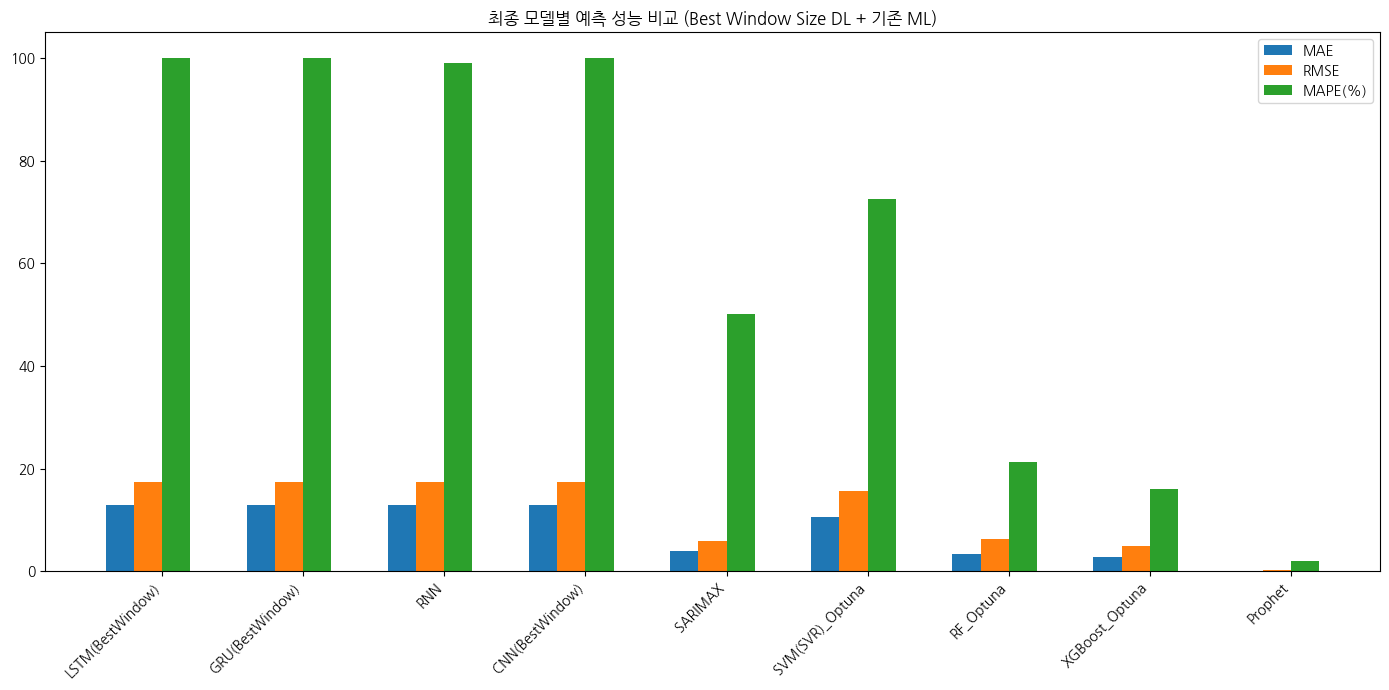


작업 완료! 각 모델의 성능 지표 및 튜닝 결과가 정리되었습니다.


In [ ]:
########################################
# 12. 최종 결과 비교 및 시각화
########################################
# 모델 이름 수정 (Best Window Size DL 모델)
best_lstm_row['Model'] = 'LSTM(BestWindow)'
best_gru_row['Model'] = 'GRU(BestWindow)'
best_cnn_row['Model'] = 'CNN(BestWindow)'
sarimax_result['Model'] = 'SARIMAX'
svr_result_opt['Model'] = 'SVM(SVR)_Optuna'
rf_result_opt['Model'] = 'RF_Optuna'
xgb_result_opt['Model'] = 'XGBoost_Optuna'
prophet_result['Model'] = 'Prophet'

final_results_df_window = pd.DataFrame([
    best_lstm_row.to_dict(),
    best_gru_row.to_dict(),
    best_rnn_row.to_dict(),
    best_cnn_row.to_dict(),
    sarimax_result,
    svr_result_opt,
    rf_result_opt,
    xgb_result_opt,
    prophet_result,

])
final_results_df_window = final_results_df_window[['Model', 'Time Steps', 'Best Params', 'MAE', 'RMSE', 'MAPE']]
final_results_df_window.fillna('-', inplace=True)
print("\n=== 최종 모델별 성능 지표 비교 (Best Window Size DL + 기존 ML) ===")
display(final_results_df_window)

final_results_df_window.rename(columns={'MAPE': 'MAPE(%)'}, inplace=True)
final_results_df_window['MAPE(%)'] = final_results_df_window['MAPE(%)'] * 100

plt.figure(figsize=(14,7))
bar_x = np.arange(len(final_results_df_window))
plt.bar(bar_x - 0.3, final_results_df_window['MAE'], 0.2, label='MAE')
plt.bar(bar_x - 0.1, final_results_df_window['RMSE'], 0.2, label='RMSE')
plt.bar(bar_x + 0.1, final_results_df_window['MAPE(%)'], 0.2, label='MAPE(%)')
plt.xticks(bar_x, final_results_df_window['Model'], rotation=45, ha='right')
plt.title("최종 모델별 예측 성능 비교 (Best Window Size DL + 기존 ML)")
plt.legend()
plt.tight_layout()
plt.show()

gc.collect()
print("\n작업 완료! 각 모델의 성능 지표 및 튜닝 결과가 정리되었습니다.")

In [ ]:
def evaluate_prophet_feature_importance(train_df, test_df, extra_regressors):
    # 1. 모든 regressors를 사용한 모델(기준 모델) 성능 평가
    baseline_model, baseline_forecast = train_prophet(train_df, test_df, extra_regressors)
    baseline_pred = baseline_forecast['yhat'].values
    baseline_perf = evaluate_performance(test_df['y'].values, baseline_pred, model_name="Prophet Baseline")

    # baseline_perf가 {'MAE': value, 'RMSE': value, 'MAPE': value, ...} 형태라고 가정합니다.

    importance_results = []
    for reg in extra_regressors:
        # 현재 Feature(reg)를 제외한 나머지 regressors를 사용
        regressors_subset = [r for r in extra_regressors if r != reg]
        model, forecast = train_prophet(train_df, test_df, extra_regressors=regressors_subset)
        pred = forecast['yhat'].values
        perf = evaluate_performance(test_df['y'].values, pred, model_name=f"Prophet without {reg}")

        # 성능 지표 차이 계산 (예: 기준 모델과 비교하여 MAE, RMSE, MAPE가 얼마나 증가 또는 감소했는지)
        # 값이 작아진다면 해당 변수의 제거가 성능 향상에 기여한 것으로 해석할 수 있습니다.
        diff_mae = baseline_perf['MAE'] - perf['MAE']
        diff_rmse = baseline_perf['RMSE'] - perf['RMSE']
        diff_mape = baseline_perf['MAPE'] - perf['MAPE']
        importance_results.append({
            'Dropped Regressor': reg,
            'MAE Diff': diff_mae,
            'RMSE Diff': diff_rmse,
            'MAPE Diff': diff_mape
        })
    return pd.DataFrame(importance_results)

# extra_regressors (feature_cols)를 사용하여 Prophet 모델의 Feature 중요도 평가
importance_df = evaluate_prophet_feature_importance(prophet_train, prophet_test, feature_cols)
print("Extra Regressor 제거에 따른 성능 변화:")
display(importance_df)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/3r5khvi6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/2wmobgur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64484', 'data', 'file=/tmp/tmp3hsf9dy4/3r5khvi6.json', 'init=/tmp/tmp3hsf9dy4/2wmobgur.json', 'output', 'file=/tmp/tmp3hsf9dy4/prophet_modelyku4nchn/prophet_model-20250212074919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/tfl6uj7z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/ifsn5_h9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

[Prophet Baseline] MAE=0.165, RMSE=0.201, MAPE=0.020


07:49:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/jbl8rdu1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/0m1d7r_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3274', 'data', 'file=/tmp/tmp3hsf9dy4/jbl8rdu1.json', 'init=/tmp/tmp3hsf9dy4/0m1d7r_k.json', 'output', 'file=/tmp/tmp3hsf9dy4/prophet_modeliwlknn8e/prophet_model-20250212074920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[Prophet without SO2] MAE=0.018, RMSE=0.021, MAPE=0.003


07:49:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/8hpthyqq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/fpd6ibwp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66981', 'data', 'file=/tmp/tmp3hsf9dy4/8hpthyqq.json', 'init=/tmp/tmp3hsf9dy4/fpd6ibwp.json', 'output', 'file=/tmp/tmp3hsf9dy4/prophet_model7shmjngn/prophet_model-20250212074921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[Prophet without CO] MAE=0.144, RMSE=0.174, MAPE=0.018


07:49:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/nzh7tt4k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/tq1sqbe_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8147', 'data', 'file=/tmp/tmp3hsf9dy4/nzh7tt4k.json', 'init=/tmp/tmp3hsf9dy4/tq1sqbe_.json', 'output', 'file=/tmp/tmp3hsf9dy4/prophet_modelx90gzm_k/prophet_model-20250212074921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[Prophet without O3] MAE=0.191, RMSE=0.234, MAPE=0.023


07:49:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/uj6mvxu3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/6i7kl14x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30112', 'data', 'file=/tmp/tmp3hsf9dy4/uj6mvxu3.json', 'init=/tmp/tmp3hsf9dy4/6i7kl14x.json', 'output', 'file=/tmp/tmp3hsf9dy4/prophet_modeldecumwyx/prophet_model-20250212074921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[Prophet without NO2] MAE=0.169, RMSE=0.207, MAPE=0.020


07:49:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/tg8i5l3a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/bh0i0n07.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45637', 'data', 'file=/tmp/tmp3hsf9dy4/tg8i5l3a.json', 'init=/tmp/tmp3hsf9dy4/bh0i0n07.json', 'output', 'file=/tmp/tmp3hsf9dy4/prophet_modelzulydpzu/prophet_model-20250212074923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[Prophet without 평균기온(℃)] MAE=0.424, RMSE=0.477, MAPE=0.059


07:49:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/eh5zhlih.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/crkrz4zz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44834', 'data', 'file=/tmp/tmp3hsf9dy4/eh5zhlih.json', 'init=/tmp/tmp3hsf9dy4/crkrz4zz.json', 'output', 'file=/tmp/tmp3hsf9dy4/prophet_modelqyd6badn/prophet_model-20250212074923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


[Prophet without PM25] MAE=0.198, RMSE=0.245, MAPE=0.023


07:49:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/66mm5myg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/wemj__81.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83491', 'data', 'file=/tmp/tmp3hsf9dy4/66mm5myg.json', 'init=/tmp/tmp3hsf9dy4/wemj__81.json', 'output', 'file=/tmp/tmp3hsf9dy4/prophet_modelxxrbvdj6/prophet_model-20250212074924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without Traffic] MAE=0.059, RMSE=0.064, MAPE=0.009


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/c2tq_hot.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3hsf9dy4/blnf21qh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40061', 'data', 'file=/tmp/tmp3hsf9dy4/c2tq_hot.json', 'init=/tmp/tmp3hsf9dy4/blnf21qh.json', 'output', 'file=/tmp/tmp3hsf9dy4/prophet_model5z77vz25/prophet_model-20250212074925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:49:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:49:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


[Prophet without Cases_lag1] MAE=9.330, RMSE=11.164, MAPE=1.713
[Prophet without Cases_Diff] MAE=4.484, RMSE=6.694, MAPE=0.564
Extra Regressor 제거에 따른 성능 변화:


,Dropped Regressor,MAE Diff,RMSE Diff,MAPE Diff
0,SO2,0.146918,0.180622,0.016685
1,CO,0.020831,0.026961,0.002225
2,O3,-0.025922,-0.032054,-0.003028
3,NO2,-0.003531,-0.006019,-0.000102
4,평균기온(℃),-0.258950,-0.276013,-0.039567
5,PM25,-0.033149,-0.043184,-0.003476
6,Traffic,0.106617,0.137244,0.011257
7,Cases_lag1,-9.165197,-10.962270,-1.693238
8,Cases_Diff,-4.318271,-6.492488,-0.544512


In [ ]:
## 0212 피드백 추가 k-select 방식을 통해 feature를 조사해볼것.